## Components of an HMM
An HMM has three sets of trainable parameters.

<img src="https://ppt.cc/fOUtex@.png" alt="drawing" width="500"/>


- The **transition model** is a square matrix $A$, where $A_{s', s}$ represents $p(z_t = s'|z_{t-1} = s)$, the probability of jumping from state $s$ to state $s'$. 

- The **emission model** $b_s(x_t)$ tells us $p(x_t|z_t = s)$, the probability of generating $x_t$ when the system is in state $s$. For discrete observations, the emission model is just a lookup table, with one row for each state, and one column for each observation. 

- The **state priors** tell us $p(z_1 = s)$, the probability of starting in state $s$. We use $\pi$ to denote the vector of state priors, so $\pi_s$ is the state prior for state $s$.

In [102]:
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sns.set_theme()

class HMM(torch.nn.Module):
  """
  Hidden Markov Model with discrete observations.
  """
  def __init__(self, M, N):
    super(HMM, self).__init__()
    self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N)

    # b(x_t)
    self.emission_model = EmissionModel(self.N,self.M)

    # pi
    self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.N))

class TransitionModel(torch.nn.Module):
  def __init__(self, N):
    super(TransitionModel, self).__init__()
    self.N = N
    self.unnormalized_transition_matrix = torch.nn.Parameter(torch.randn(N,N))

class EmissionModel(torch.nn.Module):
  def __init__(self, N, M):
    super(EmissionModel, self).__init__()
    self.N = N
    self.M = M
    self.unnormalized_emission_matrix = torch.nn.Parameter(torch.randn(N,M))

## Sample Function
To sample from the HMM, we start by picking a random initial state from the state prior distribution.

Then, we sample an output from the emission distribution, sample a transition from the transition distribution, and repeat.

(Notice that we pass the unnormalized model parameters through a softmax function to make them into probabilities.)


In [103]:
def sample(self, T=10):
  # Pass the parameters with softmax layer to get probability
  state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
  transition_matrix = torch.nn.functional.softmax(self.transition_model.unnormalized_transition_matrix, dim=0)
  emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

  # sample initial state
  z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
  z = []; x = []
  z.append(z_t)
  for t in range(0,T):
    # print('state_priors', state_priors)
    # print('transition_matrix', transition_matrix)
    # print('emission_matrix', emission_matrix[z_t])
    # print('z_t', z_t)
    # sample emission
    ########## [TODO](Hint: use emission matrix) ##########
    # temp = torch.matmul(state_priors, emission_matrix)
    # print('temp', temp)
    x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
    #############################
    x.append(x_t)

    # sample transition
    ########## [TODO](Hint: use transition matrix) ##########
    state_priors = transition_matrix[z_t]
    z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
    #############################
    if t < T-1: z.append(z_t)

  return x, z

# Add the sampling method to our HMM class
HMM.sample = sample

In [104]:
HMM(5, 2).sample()

([1, 3, 3, 0, 3, 4, 0, 3, 0, 3], [0, 1, 1, 0, 1, 0, 0, 1, 0, 1])

## Set Model Parameters

Assume that the system has one state for generating vowels and one state for generating consonants, and the transition matrix has 0s on the diagonal. In other words, the system cannot stay in the vowel state or the consonant state for more than one timestep.

Since we pass the transition matrix through a softmax, to get 0s you should set the unnormalized parameter values to $-\infty$.

State priors:


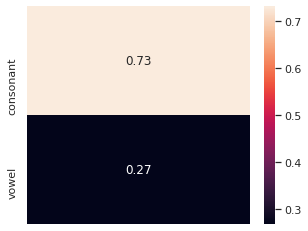

Emission matrix:


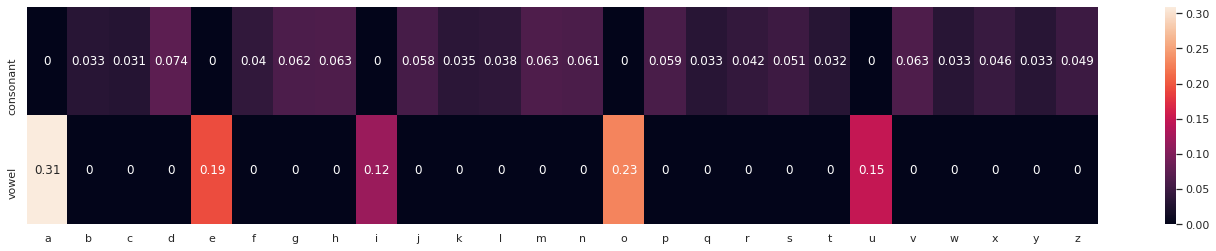

Transition matrix:


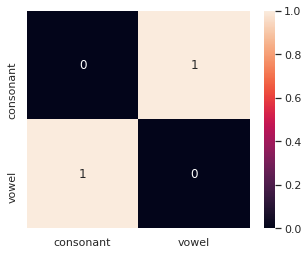

In [105]:
# Initialize the model
# The parameters are actually trainable with EM algorithm,
# but we do not implement it in this lab.
alphabet = string.ascii_lowercase
model = HMM(M=len(alphabet), N=2) 
for p in model.parameters():
    p.requires_grad = False 

# Let state 0 = consonant, state 1 = vowel
sns.set(rc={'figure.figsize':(5,4)})
########## [TODO] (Hint: consider prior) ##########
model.unnormalized_state_priors = torch.nn.Parameter(torch.tensor(
    [1, 0],
    dtype=torch.float64
), requires_grad=False)
###################################################
print("State priors:")
sns.heatmap(torch.nn.functional.softmax(model.unnormalized_state_priors, dim=0).unsqueeze(-1).numpy(),
            xticklabels=False,
            yticklabels=['consonant','vowel'],
            annot=True)
plt.show()


# In state 0, only allow consonants; in state 1, only allow vowels
sns.set(rc={'figure.figsize':(24,4)})
########## [TODO] (Hint: consider emission_model) ##########
data = [np.random.random(model.M), [-np.inf for i in range(model.M)]]
for c in 'aeiou':
  idx = string.ascii_lowercase.index(c)
  data[0][idx] = -np.inf
  data[1][idx] = np.random.random()
model.emission_model.unnormalized_emission_matrix = torch.nn.Parameter(torch.tensor(
    data,
    dtype=torch.float64
), requires_grad=False)
############################################################
print("Emission matrix:")
sns.heatmap(torch.nn.functional.softmax(model.emission_model.unnormalized_emission_matrix, dim=1).numpy(),
            xticklabels=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'],
            yticklabels=['consonant','vowel'],
            annot=True)
plt.show()


# Only allow vowel -> consonant and consonant -> vowel
sns.set(rc={'figure.figsize':(5,4)})
########## [TODO] (Hint: consider transition model) ##########
model.transition_model.unnormalized_transition_matrix = torch.nn.Parameter(torch.tensor(
    [[-np.inf, 1], [1, -np.inf]],
    dtype=torch.float64
), requires_grad=False)
#####################################################
print("Transition matrix:")
sns.heatmap(torch.nn.functional.softmax(model.transition_model.unnormalized_transition_matrix, dim=0).numpy(),
            xticklabels=['consonant','vowel'],
            yticklabels=['consonant','vowel'],
            annot=True)
plt.show()

## Sample Fake Words

In [117]:
def encode(s):
  """
  Convert a string into a list of integers
  """
  x = [alphabet.index(ss) for ss in s]
  return x

def decode(x):
  """
  Convert list of ints to string
  """
  s = "".join([alphabet[xx] for xx in x])
  return s

# Sample some outputs
for _ in range(4):
  sampled_x, sampled_z = model.sample(T=5)
  print("x:", decode(sampled_x))
  print("z:", sampled_z)

x: qevum
z: [0, 1, 0, 1, 0]
x: nedah
z: [0, 1, 0, 1, 0]
x: xanoy
z: [0, 1, 0, 1, 0]
x: ezome
z: [1, 0, 1, 0, 1]
